## Preprocessing

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import os

In [2]:
import tensorflow as tf
from tensorflow import keras

In [3]:
# to check if tensorflow is using gpu or not
len(tf.config.list_physical_devices('GPU')) > 0

True

Understanding Provided Data

In [4]:
# os.getcwd()
patient_data = pd.read_csv('Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',names=['pid','disease'])

In [5]:
# printing patient id and disease info
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [6]:
# knowing the audio text files
df = pd.read_csv("Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/203_1p4_Tc_mc_AKGC417L.txt",sep='\t',names=['start','end','crackles','wheezes'])
df.head()

,start,end,crackles,wheezes
0,0.685,2.208,0,0
1,2.208,4.577,1,0
2,4.577,6.970,1,0
3,6.970,9.351,0,0
4,9.351,11.851,0,0


The annotation text files have four columns:
- Beginning of respiratory cycle(s)
- End of respiratory cycle(s)
- Presence/absence of crackles (presence=1, absence=0)
- Presence/absence of wheezes (presence=1, absence=0)

We can extract info from the file names also as:
Each audio file name is divided into 5 elements, separated with underscores (_).

1. Patient number (101,102,...,226)
2. Recording index
3. Chest location 

      a. Trachea (Tc)

      b. Anterior left (Al)

      c. Anterior right (Ar)

      d. Posterior left (Pl)

      e. Posterior right (Pr)

      f. Lateral left (Ll)

      g. Lateral right (Lr)

4. Acquisition mode 

     a. sequential/single channel (sc), 

     b. simultaneous/multichannel (mc)

5. Recording equipment 

     a. AKG C417L Microphone (AKGC417L), 

     b. 3M Littmann Classic II SE Stethoscope (LittC2SE), 

     c. 3M Litmmann 3200 Electronic Stethoscope (Litt3200), 
     
     d.  WelchAllyn Meditron Master Elite Electronic Stethoscope (Meditron)

In [7]:
# taking the file names
import os
path='Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/'
files=[s.split('.')[0] for s in os.listdir(path) if '.txt' in s]
files[:5]

['101_1b1_Al_sc_Meditron',
 '101_1b1_Pr_sc_Meditron',
 '102_1b1_Ar_sc_Meditron',
 '103_2b2_Ar_mc_LittC2SE',
 '104_1b1_Al_sc_Litt3200']

In [8]:
def getFilenameInfo(file):
    return file.split('_')

In [9]:
getFilenameInfo('101_1b1_Al_sc_Meditron')

['101', '1b1', 'Al', 'sc', 'Meditron']

In [10]:
files_data=[]
for file in files:
    data=pd.read_csv(path + file + '.txt',sep='\t',names=['start','end','crackles','wheezes'])
    name_data=getFilenameInfo(file)
    data['pid']=name_data[0]
    data['mode']=name_data[-2]
    data['filename']=file
    files_data.append(data)
files_df=pd.concat(files_data)
files_df.reset_index()
files_df.head()

,start,end,crackles,wheezes,pid,mode,filename
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron


Join Patient Data with our Files DataFrame

In [11]:
patient_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   pid      126 non-null    int64 
 1   disease  126 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


In [12]:
files_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6898 entries, 0 to 10
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   start     6898 non-null   float64
 1   end       6898 non-null   float64
 2   crackles  6898 non-null   int64  
 3   wheezes   6898 non-null   int64  
 4   pid       6898 non-null   object 
 5   mode      6898 non-null   object 
 6   filename  6898 non-null   object 
dtypes: float64(2), int64(2), object(3)
memory usage: 431.1+ KB


Jo join based on pid, we need to make the datatype of pid in both the files same.

In [13]:
patient_data.pid=patient_data.pid.astype('int32')
files_df.pid=files_df.pid.astype('int32')

Finally, we can merge to create our data

In [14]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,start,end,crackles,wheezes,pid,mode,filename,disease
0,0.036,0.579,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
1,0.579,2.450,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
2,2.450,3.893,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
3,3.893,5.793,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI
4,5.793,7.521,0,0,101,sc,101_1b1_Al_sc_Meditron,URTI


Saving our output in csv format

In [15]:
isCsvDataExist = os.path.exists('csv_data')
if(not isCsvDataExist):
    os.makedirs('csv_data')
    data.to_csv('csv_data/data.csv',index=False)
isCsvDataExist

True

We only want that parts from whole audio file which contains Respiratory Cycles.

We will utilize the start and end time specified for these cycles in our data dataframe

In [16]:
'''
    Takes a numpy array and spilts its using start and end args
    
    raw_data=numpy array of audio sample
    start=time
    end=time
    sr=sampling_rate
    mode=mono/stereo
    by default librosa gives sr=22050
'''
def getPureSample(raw_data,start,end,sr):
    max_ind = len(raw_data) 
    start_ind = min(int(start * sr), max_ind)
    end_ind = min(int(end * sr), max_ind)
    return raw_data[start_ind: end_ind]

We multiplied start/end with sampling rate cause start is time and raw_data is array sampled according to sampling rate
Now we also want our input images to our cnn to be of same size for that audio files must be of same length i.e (start - end) must be same

We will find the best length we can have

<AxesSubplot: ylabel='pid'>

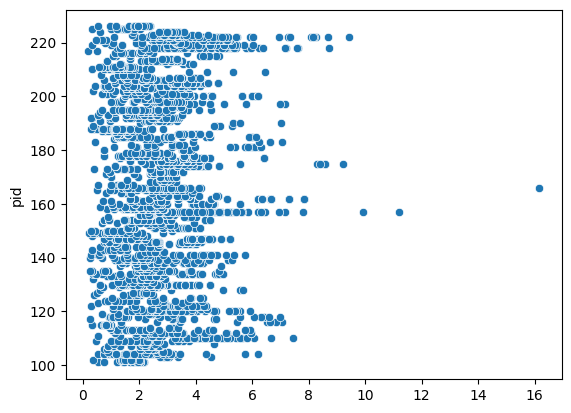

In [17]:
sns.scatterplot(x=(data.end-data.start), y=data.pid)

<AxesSubplot: >

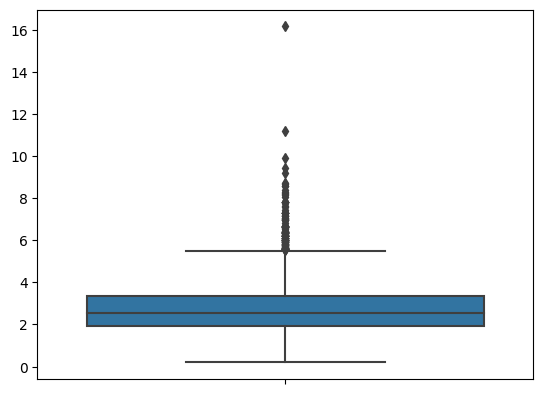

In [18]:
sns.boxplot(y=(data.end-data.start))

A boxplot is a standardized way of displaying the distribution of data based on a five number summary (“minimum”, first quartile [Q1], median, third quartile [Q3] and “maximum”).

From these plots we can conclude that best length is ~6
Also if difference is <6 we must Zero Pad it to get it to required length.

Zero-padding refers to the process of symmetrically adding zeroes to the input matrix. It's a commonly used modification that allows the size of the input to be adjusted to our requirement.

Here zero padding would mean silence.

In [19]:
# directory to store our processed audio files
isProcessedAudioFilesExist = os.path.exists('processed_audio_files')
isProcessedAudioFilesExistFlag = False

if(not isProcessedAudioFilesExist):
    os.makedirs('processed_audio_files')
    isProcessedAudioFilesExistFlag = True
isProcessedAudioFilesExist

True

A single sample of audio file can have Many Respiratory Cycles so we might have same multiple files for a single audio file

We will be using Librosa module for loading audio files and Soundfile module for writing to output path

Librosa - A python package for music and audio analysis. Librosa also normalizes the audio array.

Soundfile - The soundfile module is an audio library based on libsndfile, CFFI and NumPy. It can read and write sound files. 

In [3]:
# how single data looks in our dataframe
import librosa as lb
for index,row in data.iterrows():
    print("Index:",index)
    print("DataRow:\n",row)
    audio_file_loc=path + row['filename'] + '.wav'
    audioArr,sampleRate=lb.load(audio_file_loc)
    print("sr:",sampleRate)
    break

NameError: name 'data' is not defined

In [21]:
import soundfile as sf
if(isProcessedAudioFilesExistFlag):
    i,cnt = 0,0

    for index,row in data.iterrows():
        maxLen=6
        start=row['start']
        end=row['end']
        filename=row['filename']
        
        #If len > maxLen , change len to maxLen
        if end-start>maxLen:
            end=start+maxLen  # end - start = maxLen
        
        audio_file_loc=path + filename + '.wav'
        
        if index > 0:
            #check if more cycles exits for same patient if so then add i to change filename
            if data.iloc[index-1]['filename']==filename:
                i+=1
            else:
                i=0
        filename= filename + '_' + str(i) + '.wav'
        
        save_path='processed_audio_files/' + filename
        cnt+=1
        
        # librosa also normalizes the audio array
        audioArr,sampleRate=lb.load(audio_file_loc)
        pureSample=getPureSample(audioArr,start,end,sampleRate)
        
        #pad audio if pureSample len < max_len
        reqLen=6*sampleRate
        padded_data = lb.util.pad_center(pureSample, reqLen)
        
        sf.write(file=save_path,data=padded_data,samplerate=sampleRate)
    print('Total Files Processed: ', cnt)

## EDA, Handling Imbalance & Creating Spectrogram

In [22]:
patient_info = pd.read_csv("demographic_info.txt", names=['Patient', 'Age', 'Sex', 'BMI', 'Weight', 'Height'], delim_whitespace=True)

In [23]:
patient_info.head()

,Patient,Age,Sex,BMI,Weight,Height
0,101,3.00,F,NaN,19.0,99.0
1,102,0.75,F,NaN,9.8,73.0
2,103,70.00,F,33.00,NaN,NaN
3,104,70.00,F,28.47,NaN,NaN
4,105,7.00,F,NaN,32.0,135.0


In [24]:
patient_info['Sex'].value_counts()

M    79
F    46
Name: Sex, dtype: int64

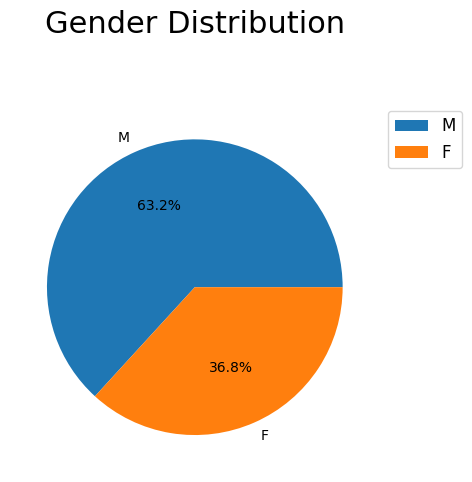

In [25]:
plt.pie(patient_info['Sex'].value_counts(), labels = ['M','F'], autopct='%1.1f%%')
plt.title("Gender Distribution", fontsize=22, pad=50.0)
plt.legend(fontsize=12, loc='best', bbox_to_anchor=(1, 1));
plt.show() 

In [4]:
import IPython.display as ipd

In [6]:
'''
Loading And Playing Audio Files
'''
filePath = 'processed_audio_files/226_1b1_Pl_sc_LittC2SE_7.wav'
ipd.Audio(filePath)

In [7]:
# librosa can convert stereo to mono audio
audio1,sample_rate1 = librosa.load(filePath,  mono=True)

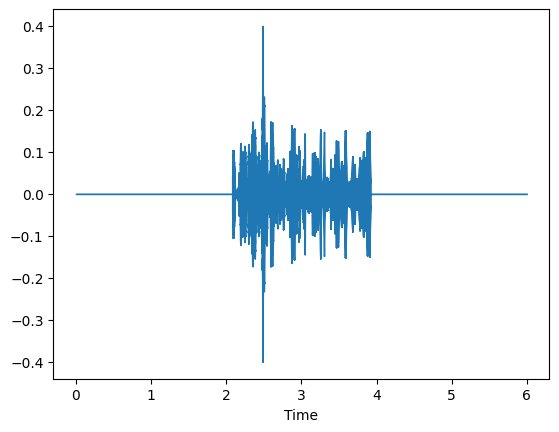

In [8]:
'''
The sampling rate is the number of samples per second. Hz or Hertz is the unit of the sampling rate.
20 kHz is the audible range for human beings.
'''

librosa.display.waveshow(audio1,sr=sample_rate1, max_points=50000, x_axis='time', offset=0)

In [30]:
import seaborn as sns
# patient_data = pd.read_csv('Respiratory_Sound_Database\Respiratory_Sound_Database\patient_diagnosis.csv',names=['pid','disease'])
patient_data.head()

,pid,disease
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

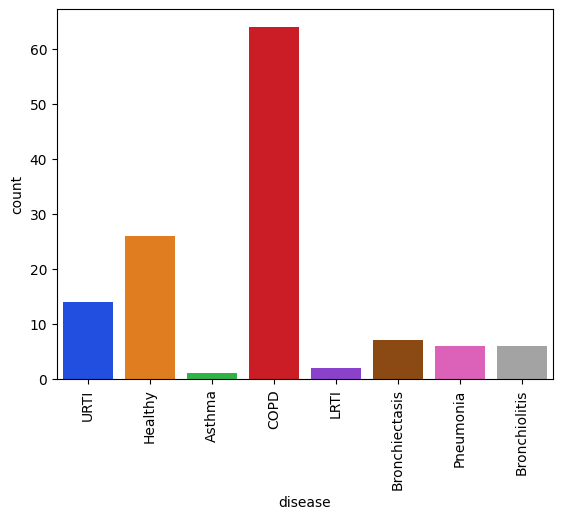

In [31]:
sns.countplot(x = 'disease', data = patient_data, palette = "bright")
plt.xticks(rotation=90)


In [32]:
# show count of each category in a column
patient_data['disease'].value_counts()

COPD              64
Healthy           26
URTI              14
Bronchiectasis     7
Pneumonia          6
Bronchiolitis      6
LRTI               2
Asthma             1
Name: disease, dtype: int64

We can see that classes are imbalanced so we must split them into train and validation set via stratify.

We will try to extract Id of each processed audio file and then merge them with their respective class label so we can split files in to train and validation folder in stratified manner.

In [33]:
def extractId(filename):
    return filename.split('_')[0]

In [34]:
path='processed_audio_files/'
length=len(os.listdir(path))
index=range(length)
i=0
files_df=pd.DataFrame(index=index,columns=['pid','filename'])
for f in os.listdir(path):
    files_df.iloc[i]['pid']=extractId(f)
    files_df.iloc[i]['filename']=f
    i+=1
files_df.head()

,pid,filename
0,101,101_1b1_Al_sc_Meditron_0.wav
1,101,101_1b1_Al_sc_Meditron_1.wav
2,101,101_1b1_Al_sc_Meditron_10.wav
3,101,101_1b1_Al_sc_Meditron_11.wav
4,101,101_1b1_Al_sc_Meditron_2.wav


In [35]:
files_df.pid=files_df.pid.astype('int64') # both pid's must be of same dtype for them to merge

In [36]:
data=pd.merge(files_df,patient_data,on='pid')
data.head()

,pid,filename,disease
0,101,101_1b1_Al_sc_Meditron_0.wav,URTI
1,101,101_1b1_Al_sc_Meditron_1.wav,URTI
2,101,101_1b1_Al_sc_Meditron_10.wav,URTI
3,101,101_1b1_Al_sc_Meditron_11.wav,URTI
4,101,101_1b1_Al_sc_Meditron_2.wav,URTI


(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'URTI'),
  Text(1, 0, 'Healthy'),
  Text(2, 0, 'Asthma'),
  Text(3, 0, 'COPD'),
  Text(4, 0, 'LRTI'),
  Text(5, 0, 'Bronchiectasis'),
  Text(6, 0, 'Pneumonia'),
  Text(7, 0, 'Bronchiolitis')])

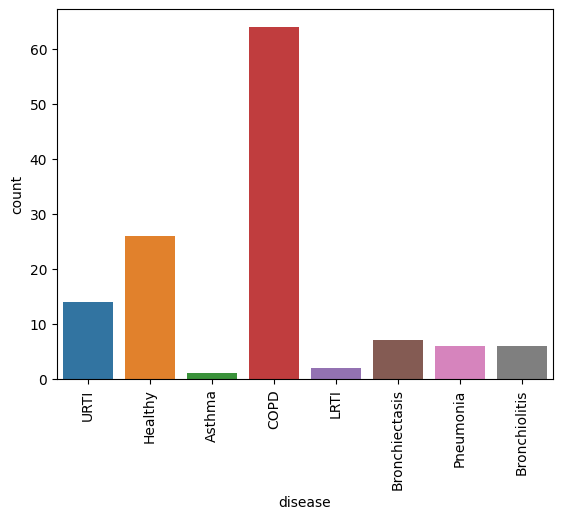

In [37]:
sns.countplot(x = 'disease', data = patient_data)
plt.xticks(rotation=90)

We can see that classes are very skewed

In [50]:
from sklearn.model_selection import train_test_split
Xtrain,Xval,ytrain,yval=train_test_split(data,data.disease,stratify=data.disease,random_state=42,test_size=0.25)

NameError: name 'data' is not defined

stratify data based on class labels and split accordingly

In [39]:
Xtrain.disease.value_counts()/Xtrain.shape[0]

COPD              0.832979
Healthy           0.046588
Pneumonia         0.041369
URTI              0.035183
Bronchiolitis     0.023197
Bronchiectasis    0.015078
LRTI              0.004639
Asthma            0.000967
Name: disease, dtype: float64

In [40]:
Xval.disease.value_counts()/Xval.shape[0]

COPD              0.833043
Healthy           0.046957
Pneumonia         0.041159
URTI              0.035362
Bronchiolitis     0.023188
Bronchiectasis    0.015072
LRTI              0.004638
Asthma            0.000580
Name: disease, dtype: float64

% of class labels is same in both train and val data set

This will help our model to learn and validate classes , it will not be like we are training only on COPD disease and there is no COPD in our validation

Visualizing Mel-Frequency Cepstral Coefficients (MFCCS)

[Text(0.5, 1.0, 'MFCC')]

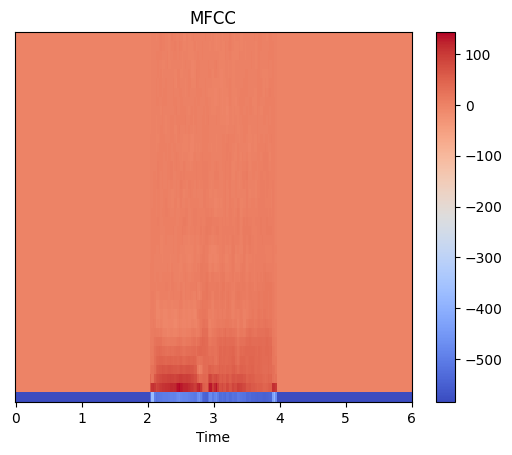

In [41]:
# Using one file for demo
sound,sample_rate=lb.load(filePath)
mfccs = lb.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40)
fig, ax = plt.subplots()
img = librosa.display.specshow(mfccs, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

x-axis = time, y-axis = decibels

In [42]:
mfccs.shape

(40, 259)

The first dimension (40) is the number of MFCC coefficients, and the second dimensions (1876) is the number of time frames. The number of MFCC is specified by n_mfcc, and the number of time frames is given by the length of the audio (in samples) divided by the hop_length

In [43]:
Xtrain.head()

,pid,filename,disease
1650,133,133_2p4_Pr_mc_AKGC417L_0.wav,COPD
2672,152,152_1b1_Al_sc_Meditron_6.wav,Healthy
548,112,112_1p1_Pr_sc_Litt3200_8.wav,COPD
4733,179,179_1b1_Al_sc_Meditron_6.wav,Healthy
1438,130,130_3p2_Ar_mc_AKGC417L_6.wav,COPD


In [44]:
ytrain.head()

1650       COPD
2672    Healthy
548        COPD
4733    Healthy
1438       COPD
Name: disease, dtype: object

In [45]:
Xval.head()

,pid,filename,disease
3592,163,163_2b2_Tc_mc_AKGC417L_4.wav,COPD
3286,158,158_2p3_Lr_mc_AKGC417L_11.wav,COPD
1051,130,130_1p2_Pr_mc_AKGC417L_3.wav,COPD
631,114,114_1b4_Pr_mc_AKGC417L_4.wav,COPD
5135,192,192_2b2_Ar_mc_LittC2SE_6.wav,COPD


In [46]:
yval.head

<bound method NDFrame.head of 3592    COPD
3286    COPD
1051    COPD
631     COPD
5135    COPD
        ... 
1917    COPD
4928    COPD
5283    COPD
2874    COPD
1946    COPD
Name: disease, Length: 1725, dtype: object>

In [47]:
# Save training and validation data
TrainingFileExist = os.path.exists('training')
ValidationFileExist = os.path.exists('validation')
if(not TrainingFileExist):
    os.makedirs('training')
    Xtrain.to_csv('training/train.csv')
if(not ValidationFileExist):
    os.makedirs('validation')
    Xval.to_csv('validation/val.csv')

Further Steps: 
- Feature Extraction using MFCC, Chroma STFT, Mel Spectrogram
- Building Our Neural Network Model
- Testing the model
- comparing our model
- Developing flask app for our model deployment

In [9]:
train=pd.read_csv('training/train.csv')
val=pd.read_csv('validation/val.csv')
train.head()

,Unnamed: 0,pid,filename,disease
0,1650,133,133_2p4_Pr_mc_AKGC417L_0.wav,COPD
1,2672,152,152_1b1_Al_sc_Meditron_6.wav,Healthy
2,548,112,112_1p1_Pr_sc_Litt3200_8.wav,COPD
3,4733,179,179_1b1_Al_sc_Meditron_6.wav,Healthy
4,1438,130,130_3p2_Ar_mc_AKGC417L_6.wav,COPD


In [10]:
ytrain=train.disease
yval=val.disease
yval

0       COPD
1       COPD
2       COPD
3       COPD
4       COPD
        ... 
1720    COPD
1721    COPD
1722    COPD
1723    COPD
1724    COPD
Name: disease, Length: 1725, dtype: object

In [11]:
yval.info()

<class 'pandas.core.series.Series'>
RangeIndex: 1725 entries, 0 to 1724
Series name: disease
Non-Null Count  Dtype 
--------------  ----- 
1725 non-null   object
dtypes: object(1)
memory usage: 13.6+ KB


class labels are of dtype: object we must first convert them to encoded values or intergers

In [12]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
ytrain=le.fit_transform(ytrain)
yval=le.transform(yval)

In [13]:
yval

array([3, 3, 3, ..., 3, 3, 3])

## Feature Extraction

In [14]:
def getFeatures(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In These functions we are iterating over train and val dataset, and using filenames to extract features and then converting them to numpy arrays

In [18]:
root='processed_audio_files/'
mfcc,cstft,mSpec = [],[],[]

for idx,row in train.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_train=np.array(mfcc)
cstft_train=np.array(cstft)
mSpec_train=np.array(mSpec)

c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification\venv\lib\site-packages\librosa\util\decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [79]:
mfcc_train

array([[[-549.5537 , -549.5537 , -549.5537 , ..., -549.5537 ,
         -549.5537 , -549.5537 ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ]],

       [[-589.45197, -589.45197, -589.45197, ..., -589.45197,
         -589.45197, -589.45197],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   

In [80]:
# saving variables so we do not have to extract them again
# convert 3d arr to 2d to save it
# while loading need to reshape back to 3d

mfcc_reshaped = mfcc_train.reshape(mfcc_train.shape[0], -1)
cstft_reshaped = cstft_train.reshape(cstft_train.shape[0], -1)
mSpec_reshaped = mSpec_train.reshape(mSpec_train.shape[0], -1)
print(mfcc_reshaped)
np.savetxt('mfcc_variable_train.txt', mfcc_reshaped)
np.savetxt('cstft_variable_train.txt', cstft_reshaped)
np.savetxt('mSpec_variable_train.txt', mSpec_reshaped)

[[-549.5537  -549.5537  -549.5537  ...    0.         0.         0.     ]
 [-589.45197 -589.45197 -589.45197 ...    0.         0.         0.     ]
 [-569.3674  -569.3674  -569.3674  ...    0.         0.         0.     ]
 ...
 [-480.87756 -480.87756 -480.87756 ...    0.         0.         0.     ]
 [-499.73483 -499.73483 -499.73483 ...    0.         0.         0.     ]
 [-504.26254 -504.26254 -504.26254 ...    0.         0.         0.     ]]


In [15]:
# loading variable files
mfcc_train = np.loadtxt('mfcc_variable_train.txt')
cstft_train = np.loadtxt('cstft_variable_train.txt')
mSpec_train = np.loadtxt('mSpec_variable_train.txt')

In [16]:
mfcc_train

array([[-549.55371094, -549.55371094, -549.55371094, ...,    0.        ,
           0.        ,    0.        ],
       [-589.45196533, -589.45196533, -589.45196533, ...,    0.        ,
           0.        ,    0.        ],
       [-569.36737061, -569.36737061, -569.36737061, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [-480.87756348, -480.87756348, -480.87756348, ...,    0.        ,
           0.        ,    0.        ],
       [-499.73483276, -499.73483276, -499.73483276, ...,    0.        ,
           0.        ,    0.        ],
       [-504.26254272, -504.26254272, -504.26254272, ...,    0.        ,
           0.        ,    0.        ]])

In [17]:
# back to original variable
mfcc_train = mfcc_train.reshape(
    mfcc_train.shape[0], mfcc_train.shape[1] // 259 , 259)

mfcc_train   # original mfcc array mfcc.shape[2] = 259 (back to 3d array)

array([[[-549.55371094, -549.55371094, -549.55371094, ...,
         -549.55371094, -549.55371094, -549.55371094],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        ...,
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ]],

       [[-589.45196533, -589.45196533, -589.45196533, ...,
         -589.45196533, -589.45196533, -589.45196533],
        [   0.        ,    0.        ,    0.        , ...,
            0.        ,    0.        ,    0.        ],
        [   0.        ,    0.        ,    0.        , ...,
            0.

In [18]:
# back to original variable
cstft_train = cstft_train.reshape(
    cstft_train.shape[0], cstft_train.shape[1] // 259 , 259)

cstft_train   # original mfcc array cstft_train.shape[2] = 259

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [19]:
# back to original variable
mSpec_train = mSpec_train.reshape(
    mSpec_train.shape[0], mSpec_train.shape[1] // 259 , 259)

mSpec_train   # original mfcc array mSpec_train.shape[2] = 259

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Chroma STFT The Chroma value of an audio basically represent the intensity of the twelve distinctive pitch classes that are used to study music. They can be employed in the differentiation of the pitch class profiles between audio signals. Chroma STFT in used short-term Fourier transformation to compute Chroma features. STFT represents information about the classification of pitch and signal structure. It depicts the spike with high values (as evident from the color bar net to the graph) in low values (dark regions).

Need to plot graph

In [19]:
mfcc,cstft,mSpec = [],[],[]

for idx,row in val.iterrows():
    path=root + row['filename']
    a,b,c=getFeatures(path)
    mfcc.append(a)
    cstft.append(b)
    mSpec.append(c)
    
mfcc_val=np.array(mfcc)
cstft_val=np.array(cstft)
mSpec_val=np.array(mSpec)

In [97]:
mfcc_val

array([[[-504.4937 , -504.4937 , -504.4937 , ..., -504.4937 ,
         -504.4937 , -504.4937 ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ]],

       [[-448.23465, -448.23465, -448.23465, ..., -448.23465,
         -448.23465, -448.23465],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        ...,
        [   0.     ,    0.     ,    0.     , ...,    0.     ,
            0.     ,    0.     ],
        [   

In [99]:
print(mfcc_val.shape)
print(cstft_val.shape)
print(mSpec_val.shape)

(1725, 20, 259)
(1725, 12, 259)
(1725, 128, 259)


In [20]:
mfcc_train.shape

(5173, 20, 259)

In [95]:
cstft_train.shape

(5173, 12, 259)

In [96]:
mSpec_train.shape

(5173, 128, 259)

The shape of features returned by the above function (20, 259) (12, 259) (128, 259) we need this for defining input shape of our model.

In [100]:
mfcc_reshaped = mfcc_val.reshape(mfcc_val.shape[0], -1)
cstft_reshaped = cstft_val.reshape(cstft_val.shape[0], -1)
mSpec_reshaped = mSpec_val.reshape(mSpec_val.shape[0], -1)
print(mfcc_reshaped)
np.savetxt('mfcc_variable_val.txt', mfcc_reshaped)
np.savetxt('cstft_variable_val.txt', cstft_reshaped)
np.savetxt('mSpec_variable_val.txt', mSpec_reshaped)

[[-504.4937  -504.4937  -504.4937  ...    0.         0.         0.     ]
 [-448.23465 -448.23465 -448.23465 ...    0.         0.         0.     ]
 [-459.84296 -459.84296 -459.84296 ...    0.         0.         0.     ]
 ...
 [-504.8329  -504.8329  -504.8329  ...    0.         0.         0.     ]
 [-489.2927  -489.2927  -489.2927  ...    0.         0.         0.     ]
 [-435.8968  -435.8968  -435.8968  ...    0.         0.         0.     ]]


In [21]:
# loading variable files
mfcc_val = np.loadtxt('mfcc_variable_val.txt')
cstft_val = np.loadtxt('cstft_variable_val.txt')
mSpec_val = np.loadtxt('mSpec_variable_val.txt')

In [22]:
mfcc_val = mfcc_val.reshape(
    mfcc_val.shape[0], mfcc_val.shape[1] // 259 , 259)
cstft_val = cstft_val.reshape(
    cstft_val.shape[0], cstft_val.shape[1] // 259 , 259)
mSpec_val = mSpec_val.reshape(
    mSpec_val.shape[0], mSpec_val.shape[1] // 259 , 259)

In [23]:
mfcc_val.shape

(1725, 20, 259)

## Building Model

In [24]:
# Lets create model using Keras Functional API to check how the features perform.
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001,mode='min')
]

### Here we are creating three different neural networks and then Combining them to a Dense Network

In [25]:
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfcc_model=keras.Model(mfcc_input, mfcc_output, name="mfccModel")

In [26]:
mfcc_model.summary()

Model: "mfccModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfccInput (InputLayer)      [(None, 20, 259, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 20, 87, 32)        832       
                                                                 
 batch_normalization (BatchN  (None, 20, 87, 32)       128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 20, 87, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 43, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 22, 64)        18

In [27]:
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

In [28]:
croma_model.summary()

Model: "cromaModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cromaInput (InputLayer)     [(None, 12, 259, 1)]      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 87, 32)        832       
                                                                 
 batch_normalization_4 (Batc  (None, 12, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_4 (Activation)   (None, 12, 87, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 43, 32)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 22, 64)         1

In [29]:
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

In [31]:
mSpec_model.summary()

Model: "mSpecModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mSpecInput (InputLayer)     [(None, 128, 259, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 87, 32)        832       
                                                                 
 batch_normalization_7 (Batc  (None, 64, 87, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_7 (Activation)   (None, 64, 87, 32)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 22, 64)        1

Concatenating our 3 models

In [46]:
input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfcc_model(input_mfcc)

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)


concat=keras.layers.concatenate([mfcc,croma,mSpec])
hidden=keras.layers.Dropout(0.1)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.2)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.2)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

net=keras.Model([input_mfcc,input_croma,input_mSpec], output, name="Net")

In [47]:
net.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [54]:
keras.utils.plot_model(net, "combined_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [48]:
from keras import backend as K
net.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(net.optimizer.learning_rate, 0.001)

In [49]:
history=net.fit(
    {"mfcc":mfcc_train,"croma":cstft_train,"mspec":mSpec_train},
    ytrain,
    validation_data=({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)

Epoch 1/100
162/162 [==============================] - 15s 63ms/step - loss: 0.4703 - accuracy: 0.8394 - val_loss: 0.3340 - val_accuracy: 0.8812 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 17s 103ms/step - loss: 0.2581 - accuracy: 0.9084 - val_loss: 0.2396 - val_accuracy: 0.9229 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 17s 104ms/step - loss: 0.2012 - accuracy: 0.9291 - val_loss: 0.3319 - val_accuracy: 0.9078 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 17s 103ms/step - loss: 0.1735 - accuracy: 0.9389 - val_loss: 0.5754 - val_accuracy: 0.8046 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 17s 106ms/step - loss: 0.1577 - accuracy: 0.9470 - val_loss: 0.6224 - val_accuracy: 0.7930 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 18s 111ms/step - loss: 0.1088 - accuracy: 0.9611 - val_loss: 0.1865 - val_accuracy: 0.9443 - lr: 1.0000e-04
Epoch 7/100
162/162 [======================

In [50]:
history.history['accuracy']

[0.8393582105636597,
 0.9083703756332397,
 0.9290546774864197,
 0.9389135837554932,
 0.9470326900482178,
 0.9611443877220154,
 0.9671370387077332,
 0.9702300429344177,
 0.9700367450714111,
 0.9735163450241089,
 0.9773825407028198,
 0.9775758981704712,
 0.9797022938728333,
 0.9785424470901489,
 0.980668842792511]

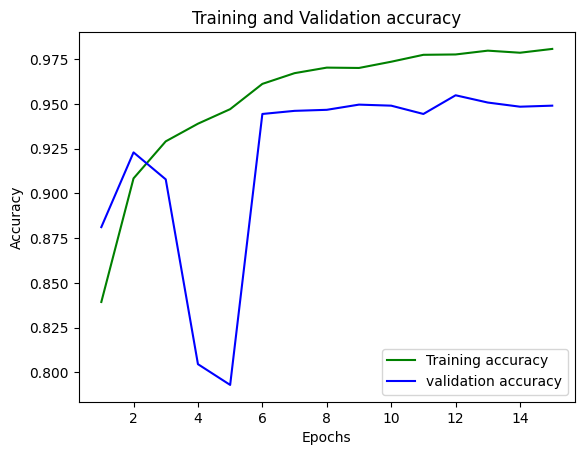

In [52]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,16)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

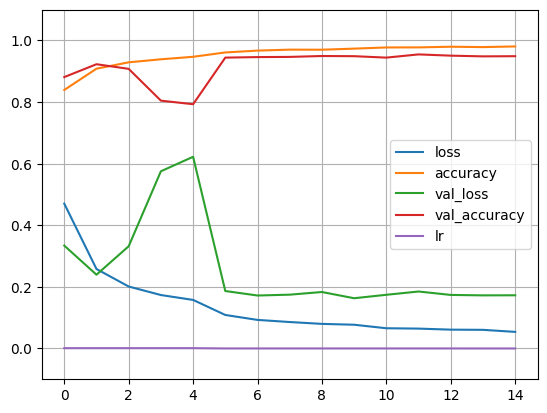

In [53]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

## Evaluating and Saving Our Model

In [54]:
net.evaluate({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val},yval)

54/54 [==============================] - 1s 23ms/step - loss: 0.1727 - accuracy: 0.9490


[0.17270150780677795, 0.9489855170249939]

In [55]:
yval

array([3, 3, 3, ..., 3, 3, 3])

In [57]:
ypred = net.predict({"mfcc":mfcc_val,"croma":cstft_val,"mspec":mSpec_val})

54/54 [==============================] - 2s 21ms/step


In [61]:
yPred = []
for i in ypred:
    yPred.append(np.argmax(i))
yPred

[3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 6,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 1,
 6,
 3,
 3,
 2,
 3,
 3,
 2,
 7,
 3,
 3,
 3,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 3,
 4,
 3,
 3,
 3,
 1,
 3,
 3,
 1,
 4,
 3,
 3,
 3,
 1,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 7,
 3,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 3,
 3,
 3,
 7,
 2,
 3,
 3,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 6,
 4,
 3,
 3,


In [62]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [63]:
print('\nClassification Report\n')
from sklearn.metrics import classification_report
print(classification_report(yval, yPred, target_names=['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']))


Classification Report

                precision    recall  f1-score   support

        Asthma       0.00      0.00      0.00         1
Bronchiectasis       0.96      0.88      0.92        26
 Bronchiolitis       0.74      0.50      0.60        40
          COPD       0.99      0.99      0.99      1437
       Healthy       0.79      0.81      0.80        81
          LRTI       0.33      0.12      0.18         8
     Pneumonia       0.80      0.93      0.86        71
          URTI       0.62      0.67      0.65        61

      accuracy                           0.95      1725
     macro avg       0.65      0.61      0.62      1725
  weighted avg       0.95      0.95      0.95      1725



c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use 

In [43]:
# saving model
from tensorflow.keras.models import save_model
modelExist = os.path.exists('model')
if(not modelExist):
    os.makedirs('model')
    save_model(net, "model/model.h5")
    # net.save(filepath='model/',overwrite=True,include_optimizer=True)

## Testing our Model for single input sound file

In [44]:
# load model
# model = keras.models.load_model('model') if model not saved in h5 format
from tensorflow.keras.models import load_model
 
# load model
model = load_model('model/model.h5')
# summarize model.
model.summary()

Model: "Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mfcc (InputLayer)              [(None, 20, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 croma (InputLayer)             [(None, 12, 259, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 mspec (InputLayer)             [(None, 128, 259, 1  0           []                               
                                )]                                                              

In [6]:
import librosa as lb
def getFeaturesForNeuralNetwork(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [77]:
# testing soundfile path

COPD = "113_1b1_Ll_sc_Litt3200_2.wav"
Pneumonia = "135_2b3_Al_mc_LittC2SE_3.wav"
URTI = "119_1b1_Ar_sc_Meditron_0.wav"
Healthy = "159_1b1_Ar_sc_Meditron_3.wav"
Bronchiectasis = "111_1b2_Tc_sc_Meditron_2.wav"
Bronchiolitis = "149_1b1_Pl_sc_Meditron_10.wav"
Asthma = "103_2b2_Ar_mc_LittC2SE_3.wav"

soundFilePath = os.getcwd() + "\processed_audio_files\\" + COPD
print(os.getcwd())
print(soundFilePath)

c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification
c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification\processed_audio_files\113_1b1_Ll_sc_Litt3200_2.wav


In [78]:
isExist = os.path.exists(soundFilePath)
print(isExist)

True


In [79]:
mfcc_test, croma_test, mspec_test = getFeaturesForNeuralNetwork(soundFilePath)

In [40]:
# cannot directly input mfcc_test, croma_test, mspec_test, be careful of dimensions
import numpy as np
mfcc,cstft,mSpec = [],[],[]
mfcc.append(mfcc_test)
cstft.append(croma_test)
mSpec.append(mspec_test)

mfcc_test = np.array(mfcc)
cstft_test = np.array(cstft)
mspec_test = np.array(mSpec)
print(mfcc_test.shape)
print(cstft_test.shape)
print(mspec_test.shape)

(1, 20, 259)
(1, 12, 259)
(1, 128, 259)


In [81]:
result = model.predict({"mfcc":mfcc_test,"croma":cstft_test,"mspec":mspec_test})

1/1 [==============================] - 0s 401ms/step


In [82]:
# print(le.classes_)
# After label encoding we get
# array(['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy',
#        'LRTI', 'Pneumonia', 'URTI'], dtype=object)
diseaseArray = ['Asthma', 'Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'LRTI', 'Pneumonia', 'URTI']
result = result.flatten()
indexMax = np.argmax(result)
indexSecMax = 0
secMax = result[0]
for smx in range(len(result)):
    if(result[smx] > secMax and result[smx] < result[indexMax]):
        indexSecMax = smx
        secMax = result[smx]

print(index)
print(result)
print(indexSecMax)

range(0, 6898)
[4.3220174e-30 8.8374248e-18 4.1484543e-25 1.0000000e+00 2.4709478e-23
 1.0612244e-34 1.5295542e-15 1.1206554e-24]
6


In [83]:
# 2 most prominent disorders
print("Disorders Detected:")
print("respiratory disorder detected: " + str(diseaseArray[indexMax]) + " with probability " + str(result[indexMax] * 100) + "%")
print("respiratory disorder detected: " + str(diseaseArray[indexSecMax]) + " with probability " + str(result[indexSecMax] * 100) + "%")


Disorders Detected:
respiratory disorder detected: COPD with probability 100.0%
respiratory disorder detected: Pneumonia with probability 1.5295542025808048e-13%


## Training and Testing individual models for comparison

MFCC Model

In [69]:
# modelExist = os.path.exists('trainedModel')
# if(not modelExist):
mfcc_input=keras.layers.Input(shape=(20,259,1),name="mfccInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(mfcc_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mfcc_output=keras.layers.GlobalMaxPooling2D()(x)

mfccModel=keras.Model(mfcc_input, mfcc_output, name="mfccModel")


input_mfcc=keras.layers.Input(shape=(20,259,1),name="mfcc")
mfcc=mfccModel(input_mfcc)

concat=keras.layers.concatenate([mfcc])
hidden=keras.layers.Dropout(0.3)(concat)
hidden=keras.layers.Dense(100,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(12,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

mfcc_model=keras.Model([input_mfcc], output, name="mfcc_model")


In [70]:
# modelExist = os.path.exists('trainedModel')
# if(not modelExist):
from keras import backend as K
mfcc_model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(mfcc_model.optimizer.learning_rate, 0.001)

In [71]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    history=mfcc_model.fit(
        {"mfcc":mfcc_train},
        ytrain,
        validation_data=({"mfcc":mfcc_val},yval),
        epochs=100,verbose=1,
        callbacks=my_callbacks
    )


Epoch 1/100
162/162 [==============================] - 4s 17ms/step - loss: 0.8866 - accuracy: 0.7593 - val_loss: 0.8987 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 2s 14ms/step - loss: 0.5818 - accuracy: 0.8260 - val_loss: 0.5933 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 2s 14ms/step - loss: 0.5015 - accuracy: 0.8320 - val_loss: 0.5277 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 2s 14ms/step - loss: 0.4800 - accuracy: 0.8322 - val_loss: 0.6199 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 2s 14ms/step - loss: 0.4550 - accuracy: 0.8314 - val_loss: 0.4132 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 2s 14ms/step - loss: 0.4328 - accuracy: 0.8326 - val_loss: 0.5941 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - 2s 

In [42]:
from tensorflow.keras.models import save_model
save_model(mfcc_model, "mfccTrained1.h5")

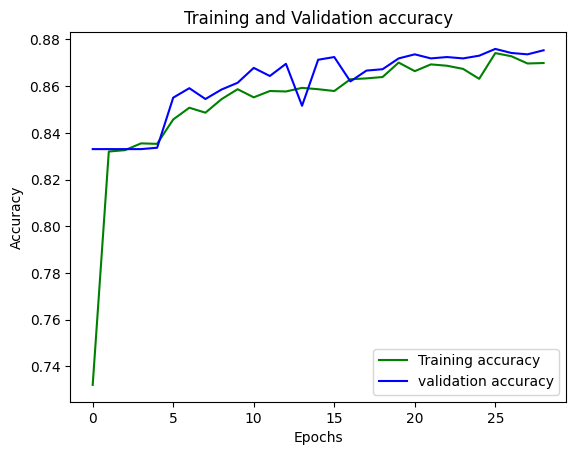

In [73]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,29)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

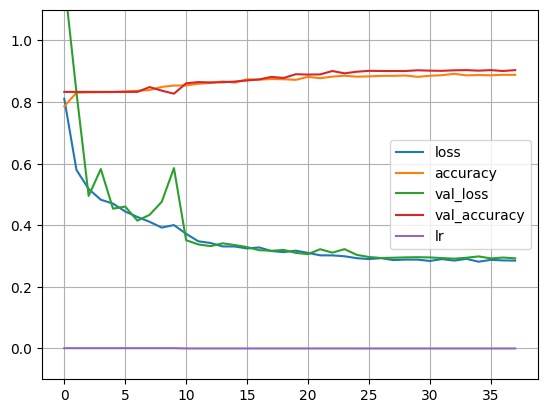

In [45]:
pd.DataFrame(history.history).plot()
plt.grid(True)
plt.gca().set_ylim(-0.1,1.1)
plt.show()

In [112]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    mfcc_model.evaluate({"mfcc":mfcc_val},yval)

54/54 [==============================] - 0s 8ms/step - loss: 0.3469 - accuracy: 0.8655


[0.34692323207855225, 0.8655072450637817]

In [88]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    mfcc_model.summary()

Model: "mfcc_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mfcc (InputLayer)           [(None, 20, 259, 1)]      0         
                                                                 
 mfccModel (Functional)      (None, 128)               94560     
                                                                 
 concatenate_1 (Concatenate)  (None, 128)              0         
                                                                 
 dense_3 (Dense)             (None, 50)                6450      
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 8)                 408       
                                                                 
Total params: 101,418
Trainable params: 100,778
Non-trai

CHROMA Model

In [74]:
# modelExist = os.path.exists('trainedModel')
# if(not modelExist):
croma_input=keras.layers.Input(shape=(12,259,1),name="cromaInput")
x=keras.layers.Conv2D(32,5,strides=(1,3),padding='same')(croma_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(1,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
croma_output=keras.layers.GlobalMaxPooling2D()(x)

croma_model=keras.Model(croma_input, croma_output, name="cromaModel")

input_croma=keras.layers.Input(shape=(12,259,1),name="croma")
croma=croma_model(input_croma)

concat=keras.layers.concatenate([croma])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

chroma_model=keras.Model([input_croma], output, name="chroma_model")

In [75]:
# modelExist = os.path.exists('trainedModel')
# if(not modelExist):
from keras import backend as K
chroma_model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(chroma_model.optimizer.learning_rate, 0.001)

In [76]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    history=chroma_model.fit(
    {"croma":cstft_train},
    ytrain,
    validation_data=({"croma":cstft_val},yval),
    epochs=100,verbose=1,
    callbacks=my_callbacks
)


Epoch 1/100
162/162 [==============================] - 3s 12ms/step - loss: 0.9148 - accuracy: 0.7928 - val_loss: 1.8041 - val_accuracy: 0.0400 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 2s 10ms/step - loss: 0.7219 - accuracy: 0.8289 - val_loss: 1.0867 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 2s 11ms/step - loss: 0.6740 - accuracy: 0.8297 - val_loss: 0.8852 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 2s 10ms/step - loss: 0.6383 - accuracy: 0.8336 - val_loss: 0.9179 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 2s 10ms/step - loss: 0.6132 - accuracy: 0.8309 - val_loss: 0.7422 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 2s 10ms/step - loss: 0.5846 - accuracy: 0.8334 - val_loss: 0.5886 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - 2s 

In [55]:
save_model(chroma_model, "chromaTrained1.h5")

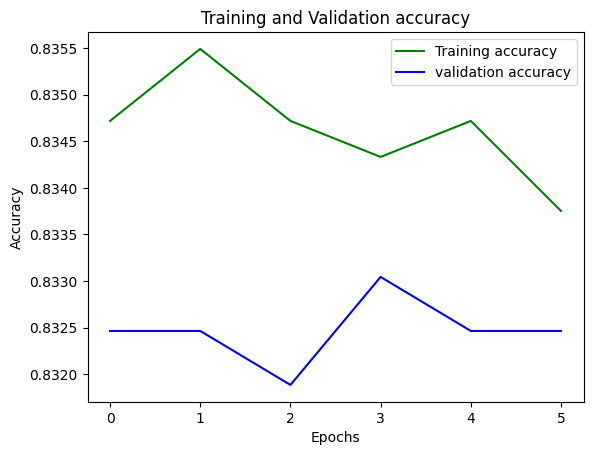

In [57]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,6)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [92]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    chroma_model.evaluate({"croma":cstft_val},yval)

54/54 [==============================] - 0s 3ms/step - loss: 0.5854 - accuracy: 0.8296


In [93]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    chroma_model.summary()

Model: "chroma_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 croma (InputLayer)          [(None, 12, 259, 1)]      0         
                                                                 
 cromaModel (Functional)     (None, 128)               53120     
                                                                 
 concatenate_2 (Concatenate)  (None, 128)              0         
                                                                 
 dense_5 (Dense)             (None, 50)                6450      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 25)                1275      
                                                                 
 dropout_7 (Dropout)         (None, 25)               

MSPEC Model

In [77]:
# modelExist = os.path.exists('trainedModel')
# if(not modelExist):
mSpec_input=keras.layers.Input(shape=(128,259,1),name="mSpecInput")
x=keras.layers.Conv2D(32,5,strides=(2,3),padding='same')(mSpec_input)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(64,3,strides=(2,2),padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(96,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
x=keras.layers.MaxPooling2D(pool_size=2,padding='valid')(x)

x=keras.layers.Conv2D(128,2,padding='same')(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Activation(keras.activations.relu)(x)
mSpec_output=keras.layers.GlobalMaxPooling2D()(x)

mSpec_model=keras.Model(mSpec_input, mSpec_output, name="mSpecModel")

input_mSpec=keras.layers.Input(shape=(128,259,1),name="mspec")
mSpec=mSpec_model(input_mSpec)

concat=keras.layers.concatenate([mSpec])
hidden=keras.layers.Dropout(0.2)(concat)
hidden=keras.layers.Dense(50,activation='relu')(concat)
hidden=keras.layers.Dropout(0.3)(hidden)
hidden=keras.layers.Dense(25,activation='relu')(hidden)
hidden=keras.layers.Dropout(0.3)(hidden)
output=keras.layers.Dense(8,activation='softmax')(hidden)

mSpec_model = keras.Model([input_mSpec], output, name="mSpec_model")

In [78]:
# modelExist = os.path.exists('trainedModel')
# if(not modelExist):
from keras import backend as K
mSpec_model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(mSpec_model.optimizer.learning_rate, 0.001)

In [79]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    history=mSpec_model.fit(
        {"mspec":mSpec_train},
        ytrain,
        validation_data=({"mspec":mSpec_val},yval),
        epochs=100,verbose=1,
        callbacks=my_callbacks
    )


Epoch 1/100
162/162 [==============================] - 4s 20ms/step - loss: 0.8993 - accuracy: 0.7669 - val_loss: 0.6354 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 3s 18ms/step - loss: 0.6718 - accuracy: 0.8309 - val_loss: 0.6164 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 3s 18ms/step - loss: 0.6174 - accuracy: 0.8312 - val_loss: 0.6035 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 3s 17ms/step - loss: 0.5888 - accuracy: 0.8322 - val_loss: 0.5488 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 3s 17ms/step - loss: 0.5508 - accuracy: 0.8316 - val_loss: 0.5619 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 3s 18ms/step - loss: 0.5313 - accuracy: 0.8324 - val_loss: 0.5072 - val_accuracy: 0.8330 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - 3s 

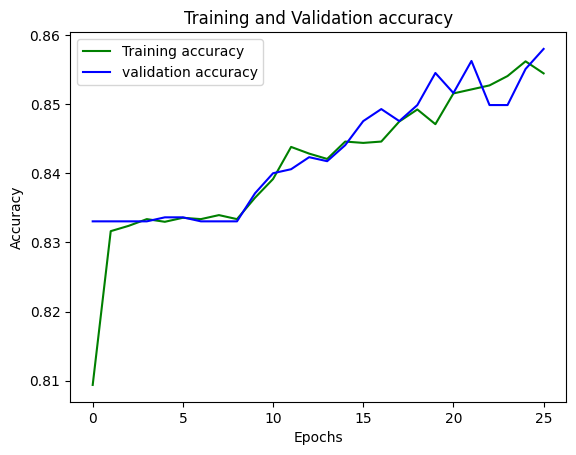

In [62]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(0,26)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [63]:
save_model(mSpec_model, "mSpecTrained1.h5")

In [97]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    mSpec_model.evaluate({"mspec":mSpec_val},yval)

54/54 [==============================] - 0s 5ms/step - loss: 0.4657 - accuracy: 0.8568


In [98]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    mSpec_model.summary()

Model: "mSpec_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mspec (InputLayer)          [(None, 128, 259, 1)]     0         
                                                                 
 mSpecModel (Functional)     (None, 128)               94560     
                                                                 
 concatenate_3 (Concatenate)  (None, 128)              0         
                                                                 
 dense_8 (Dense)             (None, 50)                6450      
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 25)                1275      
                                                                 
 dropout_10 (Dropout)        (None, 25)                

In [99]:
modelExist = os.path.exists('trainedModel')
if(not modelExist):
    os.makedirs('trainedModel')
    save_model(mfcc_model, "./trainedModel/mfcc_model.h5")
    save_model(chroma_model, "./trainedModel/chroma_model.h5")
    save_model(mSpec_model, "./trainedModel/mSpec_model.h5")

## Testing time limit taken for execution by each model

In [86]:
import librosa as lb
def getFeaturesForNeuralNetwork(path):
    soundArr,sample_rate=lb.load(path)
    mfcc=lb.feature.mfcc(y=soundArr,sr=sample_rate)
    cstft=lb.feature.chroma_stft(y=soundArr,sr=sample_rate)
    mSpec=lb.feature.melspectrogram(y=soundArr,sr=sample_rate)

    return mfcc,cstft,mSpec

In [87]:
# testing soundfile path

COPD = "113_1b1_Ll_sc_Litt3200_2.wav"
Pneumonia = "135_2b3_Al_mc_LittC2SE_3.wav"
URTI = "119_1b1_Ar_sc_Meditron_0.wav"
Healthy = "159_1b1_Ar_sc_Meditron_3.wav"
Bronchiectasis = "111_1b2_Tc_sc_Meditron_2.wav"
Bronchiolitis = "149_1b1_Pl_sc_Meditron_10.wav"
Asthma = "103_2b2_Ar_mc_LittC2SE_3.wav"

soundFilePath = os.getcwd() + "\processed_audio_files\\" + Pneumonia
print(os.getcwd())
print(soundFilePath)

c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification
c:\Users\Aditya Bapat\Desktop\project\respiratory_disorder_classification\processed_audio_files\135_2b3_Al_mc_LittC2SE_3.wav


In [88]:
mfcc_test, croma_test, mspec_test = getFeaturesForNeuralNetwork(soundFilePath)

In [89]:
# cannot directly input mfcc_test, croma_test, mspec_test, be careful of dimensions
import numpy as np
mfcc,cstft,mSpec = [],[],[]
mfcc.append(mfcc_test)
cstft.append(croma_test)
mSpec.append(mspec_test)

mfcc_test = np.array(mfcc)
cstft_test = np.array(cstft)
mspec_test = np.array(mSpec)
print(mfcc_test.shape)
print(cstft_test.shape)
print(mspec_test.shape)

(1, 20, 259)
(1, 12, 259)
(1, 128, 259)


In [90]:
# load model
# model = keras.models.load_model('model') if model not saved in h5 format
import tensorflow
import time
from tensorflow.keras.models import load_model
 
# load model

netModel = load_model('model/model.h5')

In [145]:
# Mfcc Model

counter = 0
itr = 30
for i in range(itr):
    temp = 0
    start = time.time()
    result = mfcc_model.predict({"mfcc":mfcc_test})
    end = time.time()
    temp = (end-start) * 10**3
    counter += temp
    print("The time of execution of mfcc model for iteration " + str(i) + ":",temp, "ms")
print("--------------------------------------------------------------------------")
print("Average time taken by model:",counter/itr,"ms")
    

1/1 [==============================] - 0s 33ms/step
The time of execution of mfcc model for iteration 0: 559.5338344573975 ms
1/1 [==============================] - 0s 36ms/step
The time of execution of mfcc model for iteration 1: 91.42827987670898 ms
1/1 [==============================] - 0s 30ms/step
The time of execution of mfcc model for iteration 2: 89.94746208190918 ms
1/1 [==============================] - 0s 31ms/step
The time of execution of mfcc model for iteration 3: 94.66147422790527 ms
1/1 [==============================] - 0s 40ms/step
The time of execution of mfcc model for iteration 4: 104.16150093078613 ms
1/1 [==============================] - 0s 31ms/step
The time of execution of mfcc model for iteration 5: 91.13645553588867 ms
1/1 [==============================] - 0s 25ms/step
The time of execution of mfcc model for iteration 6: 83.11271667480469 ms
1/1 [==============================] - 0s 36ms/step
The time of execution of mfcc model for iteration 7: 94.850063323

In [147]:
# MSpec Model

counter = 0
itr = 30
for i in range(itr):
    temp = 0
    start = time.time()
    result = mSpec_model.predict({"mspec":mspec_test})
    end = time.time()
    temp = (end-start) * 10**3
    counter += temp
    print("The time of execution of mSpec model for iteration " + str(i) + ":",temp, "ms")
print("--------------------------------------------------------------------------")
print("Average time taken by model:",counter/itr,"ms")

1/1 [==============================] - 0s 38ms/step
The time of execution of mSpec model for iteration 0: 92.30446815490723 ms
1/1 [==============================] - 0s 38ms/step
The time of execution of mSpec model for iteration 1: 95.57414054870605 ms
1/1 [==============================] - 0s 31ms/step
The time of execution of mSpec model for iteration 2: 85.97779273986816 ms
1/1 [==============================] - 0s 30ms/step
The time of execution of mSpec model for iteration 3: 99.37191009521484 ms
1/1 [==============================] - 0s 32ms/step
The time of execution of mSpec model for iteration 4: 135.05172729492188 ms
1/1 [==============================] - 0s 39ms/step
The time of execution of mSpec model for iteration 5: 92.41652488708496 ms
1/1 [==============================] - 0s 41ms/step
The time of execution of mSpec model for iteration 6: 95.31402587890625 ms
1/1 [==============================] - 0s 32ms/step
The time of execution of mSpec model for iteration 7: 90.8

In [133]:
# Chroma Stft Model

counter = 0
itr = 30
for i in range(itr):
    temp = 0
    start = time.time()
    result = chroma_model.predict({"croma":cstft_test})
    end = time.time()
    temp = (end-start) * 10**3
    counter += temp
    print("The time of execution of Chroma Stft model for iteration " + str(i) + ":",temp, "ms")
print("--------------------------------------------------------------------------")
print("Average time taken by model:",counter/itr,"ms")

1/1 [==============================] - 0s 32ms/step
The time of execution of Chroma Stft model for iteration 0: 101.57942771911621 ms
1/1 [==============================] - 0s 43ms/step
The time of execution of Chroma Stft model for iteration 1: 101.16696357727051 ms
1/1 [==============================] - 0s 41ms/step
The time of execution of Chroma Stft model for iteration 2: 99.40171241760254 ms
1/1 [==============================] - 0s 28ms/step
The time of execution of Chroma Stft model for iteration 3: 93.29509735107422 ms
1/1 [==============================] - 0s 30ms/step
The time of execution of Chroma Stft model for iteration 4: 87.01705932617188 ms
1/1 [==============================] - 0s 36ms/step
The time of execution of Chroma Stft model for iteration 5: 95.9770679473877 ms
1/1 [==============================] - 0s 62ms/step
The time of execution of Chroma Stft model for iteration 6: 163.59233856201172 ms
1/1 [==============================] - 0s 46ms/step
The time of exe

In [142]:
# The net concatenated model

counter = 0
itr = 30
for i in range(itr):
    temp = 0
    start = time.time()
    result = netModel.predict({"mfcc":mfcc_test,"croma":cstft_test,"mspec":mspec_test})
    end = time.time()
    temp = (end-start) * 10**3
    counter += temp
    print("The time of execution of net concatenated model for iteration " + str(i) + ":",temp, "ms")
print("--------------------------------------------------------------------------")
print("Average time taken by model:",counter/itr,"ms")

1/1 [==============================] - 0s 36ms/step
The time of execution of net concatenated model for iteration 0: 947.6566314697266 ms
1/1 [==============================] - 0s 48ms/step
The time of execution of net concatenated model for iteration 1: 123.54302406311035 ms
1/1 [==============================] - 0s 37ms/step
The time of execution of net concatenated model for iteration 2: 100.8908748626709 ms
1/1 [==============================] - 0s 39ms/step
The time of execution of net concatenated model for iteration 3: 100.33202171325684 ms
1/1 [==============================] - 0s 49ms/step
The time of execution of net concatenated model for iteration 4: 104.22229766845703 ms
1/1 [==============================] - 0s 43ms/step
The time of execution of net concatenated model for iteration 5: 118.20793151855469 ms
1/1 [==============================] - 0s 39ms/step
The time of execution of net concatenated model for iteration 6: 106.57143592834473 ms
1/1 [========================

## Conclusion

#### When we used only MFCC:
Model accuracy - 86.55 % <br />
loss - 34.69 % <br />
Time taken: 99.75 ms

#### When we used only Chroma STFT:
Model accuracy - 82.96 % <br />
loss - 58.54 % <br />
Time taken - 93.68 ms

#### When we used only mSpec:
Model accuracy - 85.68 % <br />
loss - 46.57 % <br />
Time taken - 83.74 ms

#### When taking all of them combined in a neural network:
Model Accuracy - 92.81 % <br />
loss - 20.78 % <br />
Time taken - 126.66 ms

#### Hence, we can see that mfcc, chroma stft and mSpec using them together for feature extraction not only reduces the loss but also increases our overall model accuracy.
